<a href="https://colab.research.google.com/github/ArashDehghanyan/ml-and-vision-practices/blob/main/3DImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#Download MosMedData

In [2]:
# Download url of normal CT scans
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
filename = os.path.join(os.getcwd(), "CT-0.zip")
keras.utils.get_file(filename, url)

# Download url of abnormal CT scans
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"
filename = os.path.join(os.getcwd(), "CT-23.zip")
keras.utils.get_file(filename, url)

# Unzip data
# Make a directory to store unzipped data
os.makedirs("MosMedData", exist_ok=True)

# unzip data to newly created directotry
with zipfile.ZipFile("CT-0.zip", "r") as zf:
    zf.extractall("./MosMedData")

with zipfile.ZipFile("CT-23.zip", "r") as zf:
    zf.extractall("./MosMedData")

1045176320/1045162547 [==============================] - 9s 0us/step


#Remove zip files

In [3]:
# Remove zipfiles
for item in sorted(os.listdir(os.getcwd())):
    if "zip" in item:
        os.remove(item)

#Loading and preprocessing functions

In [4]:
import nibabel as nib
from scipy import ndimage

def read_nifti_file(filepath):
    # Read file
    scan = nib.load(filepath)

    # Get raw data
    scan = scan.get_fdata(dtype=np.float32)
    return scan

def normalize(volume):
    """Normalize the Volume."""
    min_val = -1000
    max_val = 400

    volume[volume < min_val] = min_val
    volume[volume > max_val] = max_val

    volume = (volume - min_val) / (max_val - min_val)
    return volume.astype("float32")

def resize_volume(volume):
    """Resize the Volume."""

    desired_depth = 64
    desired_width = 128
    desired_height = 128

    current_width, current_height, current_depth = volume.shape
    height_factor = desired_height / current_height
    width_factor = desired_width / current_width
    depth_factor = desired_depth / current_depth

    # Rotate
    volume = ndimage.rotate(volume, 90, reshape=False)
    # Resize
    volume = ndimage.zoom(volume, (width_factor, height_factor, depth_factor), order=1)
    return volume 


def process_scan(filepath):
    """Read and resize CT scans."""
    # Read scan
    volume = read_nifti_file(filepath)

    # Normalize 
    volume = normalize(volume)

    # Rezise
    volume = resize_volume(volume)
    return volume 

#Read the paths of CT scans from the directory

In [5]:
normal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-0", x)
    for x in os.listdir("MosMedData/CT-0")
]

abnormal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-23", x)
    for x in os.listdir("MosMedData/CT-23")
]

print("CT scans with normal lung tissue:", len(normal_scan_paths))
print("CT scans with abnormal lung tissue:", len(abnormal_scan_paths))

CT scans with normal lung tissue: 100
CT scans with abnormal lung tissue: 100


In [6]:
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])

normal_labels = np.array([1 for _ in range(len(normal_scans))])
abnormal_labels = np.array([0 for _ in range(len(abnormal_scans))])

x_train = np.concatenate((abnormal_scans[:70], normal_scans[:70]), axis=0)
y_train = np.concatenate((abnormal_labels[:70], normal_labels[:70]), axis=0)
x_val = np.concatenate((abnormal_scans[70:], normal_scans[70:]), axis=0)
y_val = np.concatenate((abnormal_labels[70:], normal_labels[70:]), axis=0)
print("Number of samples in train and validation are {} and {}".format(x_train.shape[0], x_val.shape[0]))


Number of samples in train and validation are 140 and 60


#Data Augmentation

In [7]:
import random


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees."""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        
        # pick angles at random
        angle = random.choice(angles)
        # Rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume
    
    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume

def train_preprocessing(volume, label):
    """Process training data by rotate and add a dimension."""
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=-1)
    return volume, label

def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=-1)
    return volume, label
    

In [8]:
# Define data loaders
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing).batch(batch_size).prefetch(2)
)

validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing).batch(batch_size).prefetch(2)
)


#Visualize an augmented CT scan

Dimension of CT scan = (128, 128, 64, 1)


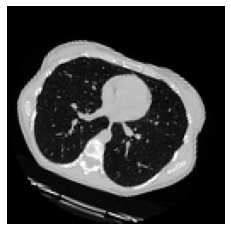

In [9]:
import matplotlib.pyplot as plt

for images, labels in train_dataset.take(1):
    images = images.numpy()
    image = images[0]
    print("Dimension of CT scan =", image.shape)
    plt.imshow(np.squeeze(image[:, :, 30]), cmap='gray')
plt.axis('off')
plt.show()

In [10]:
from IPython.core.pylabtools import figsize
# plot slices
def plot_slices(num_rows, num_columns, height, width, data):
    """Plot a montage of 40 CT scans."""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0:2]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)

    f, axes = plt.subplots(
        rows_data, columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights}
    )

    for i in range(rows_data):
        for j in range(columns_data):
            axes[i, j].imshow(data[i][j], cmap='gray')
            axes[i, j].axis('off')
    
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

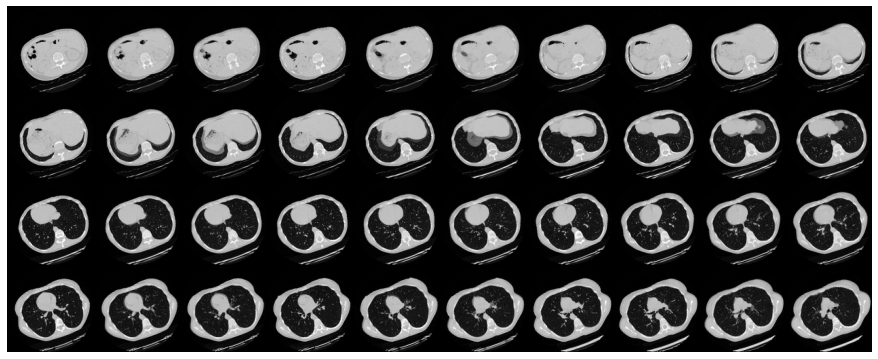

In [11]:
plot_slices(4, 10, 128, 128, image[:, :, :40])

#Define 3D Convolutional networks
##based on this [paper](https://arxiv.org/abs/2007.13224)

In [12]:
class ConvBlock(layers.Layer):
    """Define then network base block."""
    def __init__(self, num_channels=64, **kwargs):
        super(ConvBlock, self).__init__(**kwargs)
        self.channels = num_channels
        self.conv = layers.Conv3D(filters=self.channels, kernel_size=3, activation='relu')
        self.pool = layers.MaxPool3D(pool_size=2)
        self.batch_norm = layers.BatchNormalization()

    def call(self, X):
        y = self.conv(X)
        y = self.pool(y)
        y = self.batch_norm(y)
        return y
    
    def get_config(self):
        config = super(ConvBlock, self).get_config().copy()
        config.update({'num_channels': self.channels})
        return config

In [13]:
class ThreeDimensionClassifier(keras.Model):
    """Classifies lung anomalities using 3D convolution network."""

    def __init__(self, name, *args, **kwargs):
        super(ThreeDimensionClassifier, self).__init__(name=name, **kwargs)

        self.body = []
        for i in range(len(args)-1):
            self.body.append(ConvBlock(args[i]))
        self.top = []
        self.top.append(layers.GlobalAveragePooling3D())
        self.top.append(layers.Dense(units=args[-1], activation='relu'))
        self.top.append(layers.Dropout(0.3))
        self.top.append(layers.Dense(units=1, activation='sigmoid'))

    def call(self, x):
        # x = self.inputs(x)
        for block in self.body:
            x = block(x)
        for layer in self.top:
            x = layer(x)
        return x
    def get_config(self):
        config = super(ThreeDimensionClassifier, self).get_config()
        config.update({
            'top': self.top, 
            'body': self.body
        })
        return config

In [14]:
classifier = ThreeDimensionClassifier('3dcnn', 64, 64, 128, 265, 512)
classifier(images)

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.49501872],
       [0.49473011]], dtype=float32)>

In [15]:
X = images[0]
X = tf.expand_dims(X, 0)
for layer in classifier.layers:
    X = layer(X)
    print(layer.__class__.__name__, "Output shape:\t", X.shape)

ConvBlock Output shape:	 (1, 63, 63, 31, 64)
ConvBlock Output shape:	 (1, 30, 30, 14, 64)
ConvBlock Output shape:	 (1, 14, 14, 6, 128)
ConvBlock Output shape:	 (1, 6, 6, 2, 265)
GlobalAveragePooling3D Output shape:	 (1, 265)
Dense Output shape:	 (1, 512)
Dropout Output shape:	 (1, 512)
Dense Output shape:	 (1, 1)


In [16]:
channel_list = [64, 64, 128, 256]

def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network."""

    inputs = layers.Input((width, height, depth, 1))
    x = ConvBlock(channel_list.pop(0))(inputs)

    for channel in channel_list:
        x = ConvBlock(channel)(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation='sigmoid')(x)

    # Define the model
    model = keras.Model(inputs=inputs, outputs=outputs, name='3dcnn')
    return model

In [17]:
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv_block_4 (ConvBlock)    (None, 63, 63, 31, 64)    2048      
                                                                 
 conv_block_5 (ConvBlock)    (None, 30, 30, 14, 64)    110912    
                                                                 
 conv_block_6 (ConvBlock)    (None, 14, 14, 6, 128)    221824    
                                                                 
 conv_block_7 (ConvBlock)    (None, 6, 6, 2, 256)      886016    
                                                                 
 global_average_pooling3d_1   (None, 256)              0         
 (GlobalAveragePooling3D)                                    

#Train Model

In [18]:
# Compile model
initial_learning_rate = 1e-4
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.96, staircase=True
)

model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=['acc']
)

# Define callbacks
checkpoint = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)

early_stoping = keras.callbacks.EarlyStopping(
    monitor='val_acc', patience=15, mode='max'
)

epochs = 100
# Train the model
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=1,
    callbacks=[checkpoint, early_stoping]
)

Epoch 1/100
70/70 [==============================] - 27s 349ms/step - loss: 0.7079 - acc: 0.5500 - val_loss: 0.9508 - val_acc: 0.5000
Epoch 2/100
70/70 [==============================] - 26s 364ms/step - loss: 0.6723 - acc: 0.6000 - val_loss: 1.1985 - val_acc: 0.5000
Epoch 3/100
70/70 [==============================] - 26s 367ms/step - loss: 0.6144 - acc: 0.6500 - val_loss: 0.9138 - val_acc: 0.5000
Epoch 4/100
70/70 [==============================] - 26s 369ms/step - loss: 0.6948 - acc: 0.5857 - val_loss: 0.7619 - val_acc: 0.5167
Epoch 5/100
70/70 [==============================] - 27s 380ms/step - loss: 0.6503 - acc: 0.6214 - val_loss: 0.6403 - val_acc: 0.6000
Epoch 6/100
70/70 [==============================] - 26s 366ms/step - loss: 0.6549 - acc: 0.5857 - val_loss: 1.1082 - val_acc: 0.5000
Epoch 7/100
70/70 [==============================] - 26s 370ms/step - loss: 0.6627 - acc: 0.5786 - val_loss: 0.6196 - val_acc: 0.6833
Epoch 8/100
70/70 [==============================] - 26s 364ms

#Reload saved model

In [21]:
reloaded_model = keras.models.load_model(
    "3d_image_classification.h5",
    custom_objects={'ConvBlock': ConvBlock}
)
reloaded_model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv_block_4 (ConvBlock)    (None, 63, 63, 31, 64)    2048      
                                                                 
 conv_block_5 (ConvBlock)    (None, 30, 30, 14, 64)    110912    
                                                                 
 conv_block_6 (ConvBlock)    (None, 14, 14, 6, 128)    221824    
                                                                 
 conv_block_7 (ConvBlock)    (None, 6, 6, 2, 256)      886016    
                                                                 
 global_average_pooling3d_1   (None, 256)              0         
 (GlobalAveragePooling3D)                                    

In [19]:
model.save("classification.h5")

In [20]:
reloaded_model = keras.models.load_model(
    "classification.h5",
    custom_objects={'ConvBlock': ConvBlock}
)
reloaded_model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv_block_4 (ConvBlock)    (None, 63, 63, 31, 64)    2048      
                                                                 
 conv_block_5 (ConvBlock)    (None, 30, 30, 14, 64)    110912    
                                                                 
 conv_block_6 (ConvBlock)    (None, 14, 14, 6, 128)    221824    
                                                                 
 conv_block_7 (ConvBlock)    (None, 6, 6, 2, 256)      886016    
                                                                 
 global_average_pooling3d_1   (None, 256)              0         
 (GlobalAveragePooling3D)                                    

#Visualize model

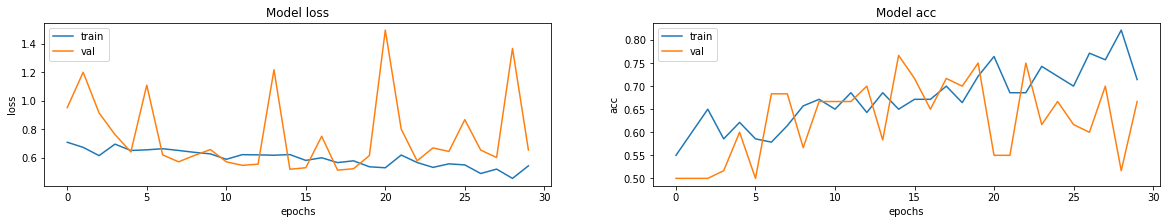

In [22]:
f, axes = plt.subplots(1, 2, figsize=(20, 3))
axes = axes.ravel()
for i, metric in enumerate(['loss', 'acc']):
    axes[i].plot(model.history.history[metric], label='train')
    axes[i].plot(model.history.history['val_' + metric], label='val')
    axes[i].set_title("Model {}".format(metric))
    axes[i].set_xlabel("epochs")
    axes[i].set_ylabel(metric)
    axes[i].legend()

#Make a prediction on a single CT scan

In [33]:
prediction = reloaded_model.predict(tf.expand_dims(x_val[0], 0))[0]
scores = [prediction[0], 1 - prediction[0]]
class_name = ['normal', 'abnormal']

for score, name in zip(scores, class_name):
    print("This model is %.2f percent confident that CT scan is %s"
     % ((100 * score), name))

This model is 33.71 percent confident that CT scan is normal
This model is 66.29 percent confident that CT scan is abnormal
